<a href="https://colab.research.google.com/github/jaouni24/ECG-PowerLine-Interference-Removal/blob/main/DSP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSP Project

## Installing Libraries

In [ ]:
!pip install wfdb

## Notch Filter

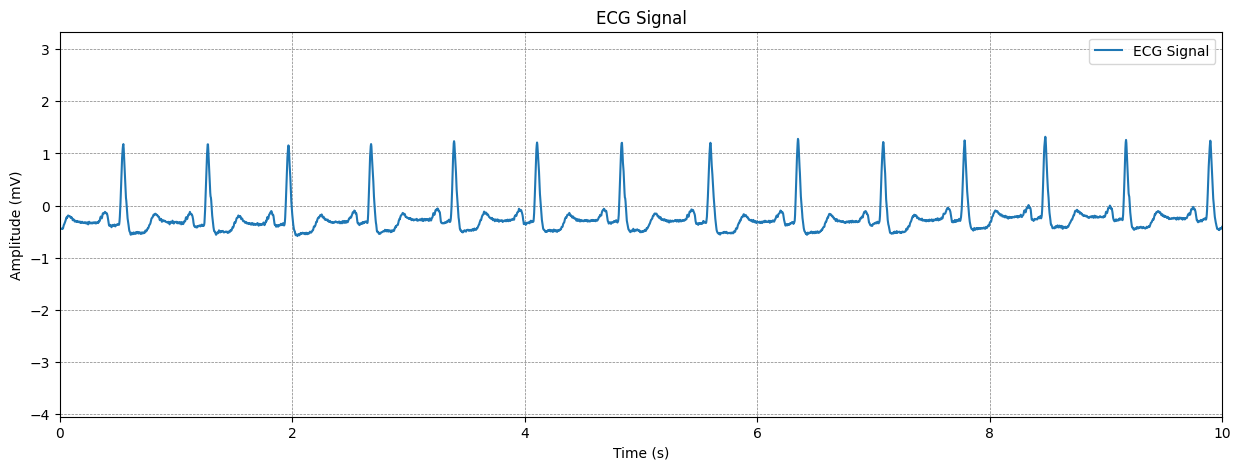

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG record and annotation
def load_and_plot_ecg(file_path):
    # Read the record (ECG signal)
    record = wfdb.rdrecord(file_path)  # Provide the base name without extensions
    annotation = wfdb.rdann(file_path, 'dat')  # 'atr' for annotation (if available)

    # Get the signal and sampling frequency
    signal = record.p_signal  # ECG signal
    fs = record.fs  # Sampling frequency (Hz)
    time = [i / fs for i in range(len(signal))]  # Generate time axis

    # Plot the ECG signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal[:, 0], label="ECG Signal")  # Assuming single-channel ECG
    plt.title("ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.xlim(0,10)
    plt.show()

# file_path = "/content/100"
# file_path = "/content/103"
# file_path = "/content/104"
file_path = "/content/105"
load_and_plot_ecg(file_path)

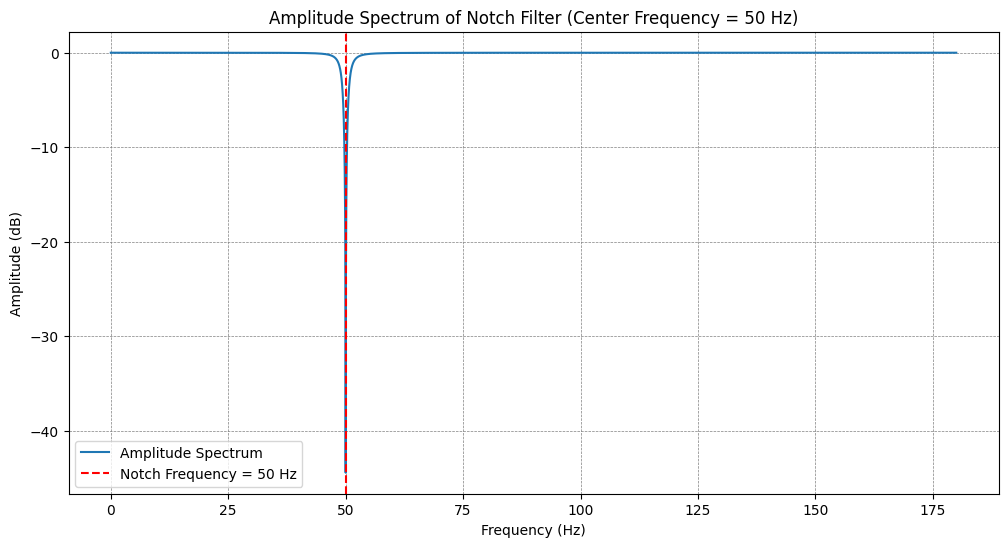

In [ ]:
import numpy as np
from scipy.signal import iirnotch, freqz
import matplotlib.pyplot as plt

# Design a notch filter
def design_notch_filter(freq, fs, quality_factor):
    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)  # Notch filter coefficients
    return b, a

# Plot the amplitude spectrum of the notch filter
def plot_notch_filter_spectrum(freq, fs, quality_factor):
    b, a = design_notch_filter(freq, fs, quality_factor)
    w, h = freqz(b, a, worN=8000, fs=fs)  # Frequency response
    plt.figure(figsize=(12, 6))
    plt.plot(w, 20 * np.log10(abs(h)), label="Amplitude Spectrum")
    plt.title(f"Amplitude Spectrum of Notch Filter (Center Frequency = {freq} Hz)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(freq, color='red', linestyle='--', label=f"Notch Frequency = {freq} Hz")
    plt.legend()
    plt.show()

# Parameters
notch_freq = 50  # Notch frequency (e.g., 50 Hz for powerline interference)
sampling_freq = 360  # Sampling frequency of the ECG signal
q_factor = 30  # Quality factor (adjust for bandwidth)

# Plot the amplitude spectrum of the notch filter
plot_notch_filter_spectrum(notch_freq, sampling_freq, q_factor)

In [ ]:
# Add 50 Hz noise to make the signal dirty
def add_powerline_noise(signal, fs, freq, amplitude):
    freq_min = 50 - 0.5  # Minimum frequency (49.5 Hz)
    freq_max = 50 + 0.5  # Maximum frequency (50.5 Hz)

    # Time vector
    time = np.arange(len(signal)) / fs

    # Generate random frequencies between freq_min and freq_max
    random_freqs = np.random.uniform(freq_min, freq_max)

    # Generate the noise with the random frequencies
    noise = amplitude * np.sin(2 * np.pi * random_freqs * time)

    # Add the noise to the original signal
    dirty_signal = signal + noise

    return dirty_signal, time

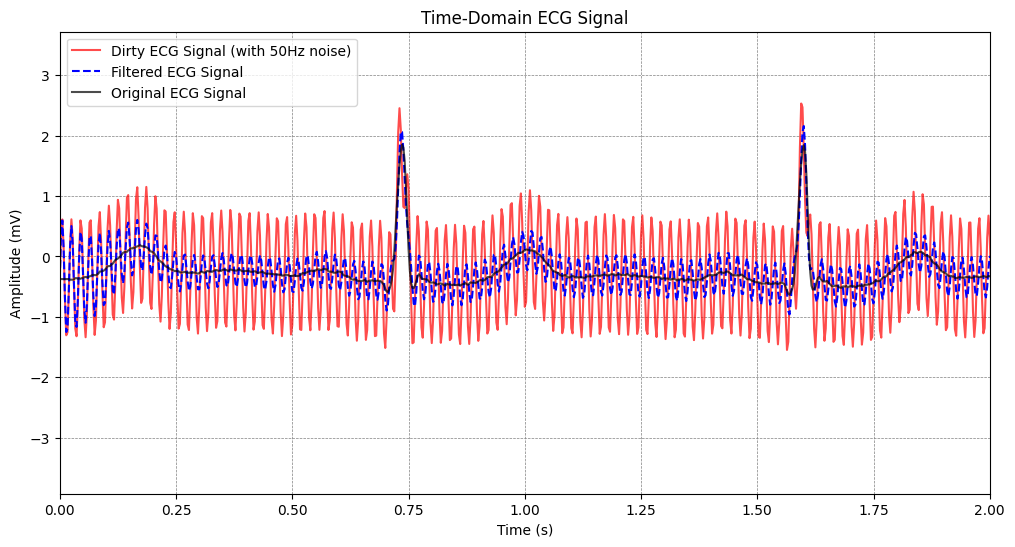

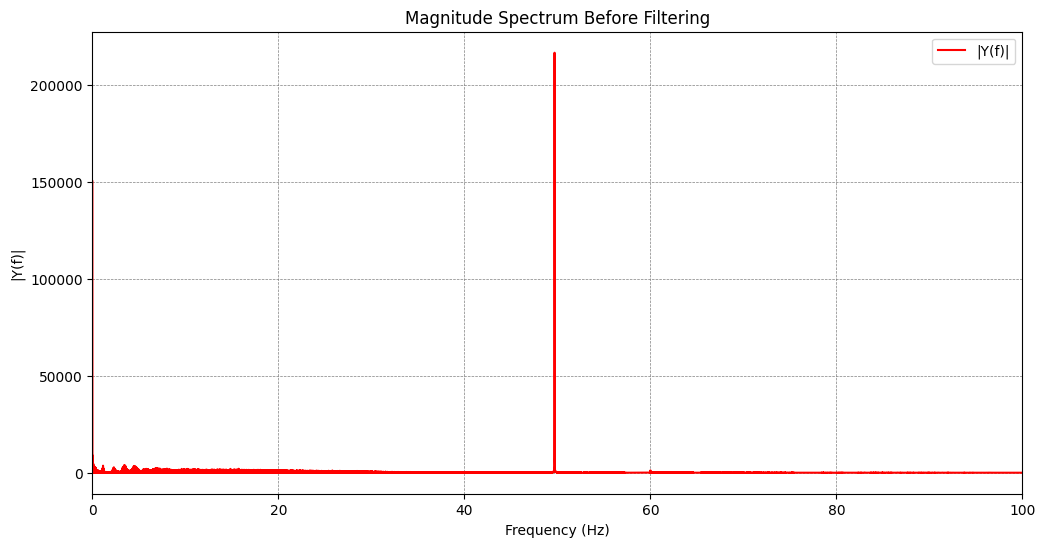

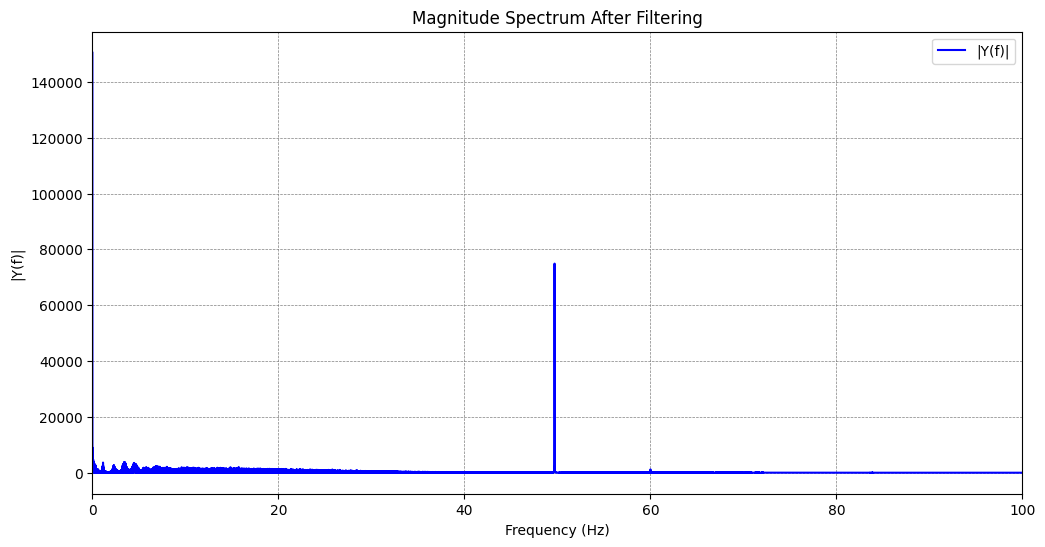

In [ ]:
import numpy as np
from scipy.signal import iirnotch, lfilter
import matplotlib.pyplot as plt
import wfdb
import random

# Load the ECG signal
def load_ecg(file_path):
    record = wfdb.rdrecord(file_path)
    signal = record.p_signal[:, 0]  # Assuming single-channel ECG
    fs = record.fs  # Sampling frequency
    return signal, fs

# Design a notch filter
def design_notch_filter(freq, fs, quality_factor):
    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return b, a

# Apply the filter to the signal
def apply_filter(signal, b, a):
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

# Plot time-domain signals
def plot_time_domain_signals(time, original_signal, dirty_signal, filtered_signal):
    plt.figure(figsize=(12, 6))
    plt.plot(time, dirty_signal, label="Dirty ECG Signal (with 50Hz noise)", alpha=0.7, color="red")
    plt.plot(time, filtered_signal, label="Filtered ECG Signal", linestyle='--', color="blue")
    plt.plot(time, original_signal, label="Original ECG Signal", color="black", alpha=0.7)
    plt.title("Time-Domain ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(0, 2)  # Display only the first second for clarity
    plt.show()

# Plot magnitude spectrum |Y(f)|
def plot_magnitude_spectrum(signal, fs, title, color):
    n = len(signal)  # Number of samples
    freq = np.fft.rfftfreq(n, d=1/fs)  # Frequency axis
    magnitude = np.abs(np.fft.rfft(signal))  # Magnitude spectrum

    plt.figure(figsize=(12, 6))
    plt.plot(freq, magnitude, label="|Y(f)|", color=color)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|Y(f)|")
    plt.xlim(0, 100)  # Focus on 0-100 Hz range
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

# File path and parameters
file_path = "/content/103"  # Replace with your actual file path
notch_freq = 50  # Notch frequency (e.g., 50 Hz for powerline interference)
q_factor = 30  # Quality factor
noise_amplitude = 1  # Amplitude of 50 Hz noise

# Load the ECG signal
ecg_signal, sampling_freq = load_ecg(file_path)

# Add 50 Hz powerline interference
dirty_ecg_signal, time = add_powerline_noise(ecg_signal, sampling_freq, notch_freq, noise_amplitude)

# Design and apply notch filter
b, a = design_notch_filter(notch_freq, sampling_freq, q_factor)
filtered_ecg_signal = apply_filter(dirty_ecg_signal, b, a)

# Plot time-domain signals (replicating Figure 3(a))
plot_time_domain_signals(time, ecg_signal, dirty_ecg_signal, filtered_ecg_signal)

# Plot magnitude spectrum before filtering (replicating Figure 3(b))
plot_magnitude_spectrum(dirty_ecg_signal, sampling_freq, "Magnitude Spectrum Before Filtering", color="red")

# Plot magnitude spectrum after filtering
plot_magnitude_spectrum(filtered_ecg_signal, sampling_freq, "Magnitude Spectrum After Filtering", color="blue")


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate SNR
def calculate_snr(original_signal, noisy_signal):
    signal_power = np.mean(original_signal ** 2)
    noise_power = np.mean((noisy_signal - original_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate %PRD
def calculate_prd(original_signal, processed_signal):
    error_signal = original_signal - processed_signal
    prd = (np.linalg.norm(error_signal) / np.linalg.norm(original_signal)) * 100
    return prd

# Function to calculate MSE
def calculate_mse(original_signal, processed_signal):
    mse = mean_squared_error(original_signal, processed_signal)
    return mse

# Calculate metrics for the dirty signal
snr_dirty = calculate_snr(ecg_signal, dirty_ecg_signal)
prd_dirty = calculate_prd(ecg_signal, dirty_ecg_signal)
mse_dirty = calculate_mse(ecg_signal, dirty_ecg_signal)

# Calculate metrics for the filtered signal
snr_filtered = calculate_snr(ecg_signal, filtered_ecg_signal)
prd_filtered = calculate_prd(ecg_signal, filtered_ecg_signal)
mse_filtered = calculate_mse(ecg_signal, filtered_ecg_signal)

# Print results
print("Dirty Signal Metrics:")
print(f"SNR: {snr_dirty:.2f} dB")
print(f"%PRD: {prd_dirty:.2f}%")
print(f"MSE: {mse_dirty:.6f}")

print("\nFiltered Signal Metrics:")
print(f"SNR: {snr_filtered:.2f} dB")
print(f"%PRD: {prd_filtered:.2f}%")
print(f"MSE: {mse_filtered:.6f}")

Dirty Signal Metrics:
SNR: -5.03 dB
%PRD: 178.38%
MSE: 0.499999

Filtered Signal Metrics:
SNR: 10.04 dB
%PRD: 31.49%
MSE: 0.015578


## NLMS Filter

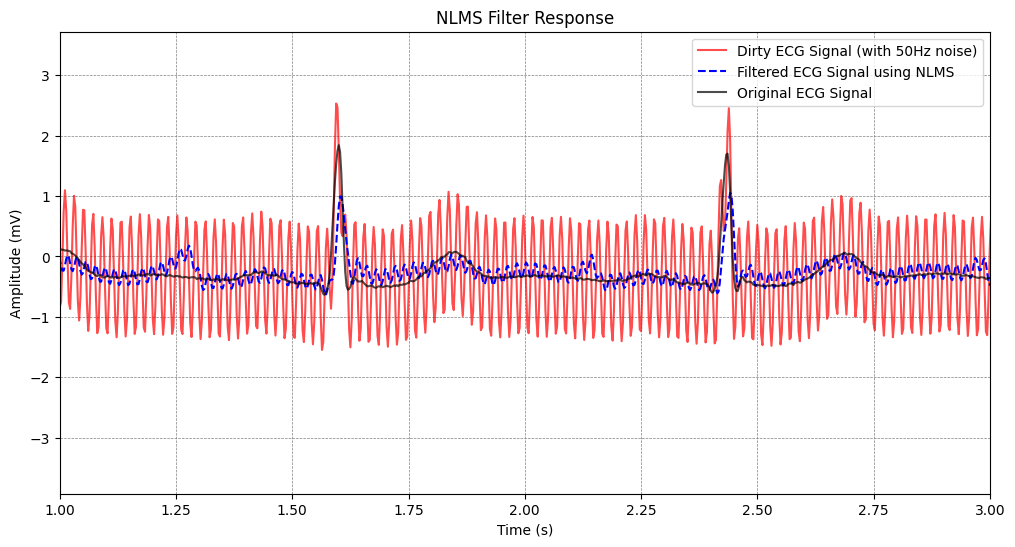

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to apply NLMS filter
def nlms_filter(dirty_signal, reference_signal, mu=0.1, filter_order=200):
    """
    Applies the NLMS filter to the dirty signal using a reference signal.

    Args:
    - dirty_signal: The input noisy signal (e.g., dirty ECG signal).
    - reference_signal: The reference signal (e.g., same dirty signal or another reference).
    - mu: The step size for NLMS (learning rate).
    - filter_order: The order of the filter (number of taps).

    Returns:
    - filtered_signal: The output signal after filtering.
    """
    N = len(dirty_signal)
    filtered_signal = np.zeros(N)  # Filtered output signal
    w = np.zeros(filter_order)  # Filter weights
    error_signal = np.zeros(N)  # Error signal (desired - actual)

    for n in range(filter_order, N):
        # Select the current window of the reference signal
        ref_window = reference_signal[n-filter_order:n]

        # Compute the output of the filter (dot product of weights and reference window)
        y = np.dot(w, ref_window)

        # Compute the error signal
        error = dirty_signal[n] - y
        error_signal[n] = error

        # Update the filter weights using the NLMS algorithm
        norm_factor = np.dot(ref_window, ref_window)  # Normalization factor (squared norm)
        if norm_factor > 0:  # To avoid division by zero
            w += (mu * error * ref_window) / norm_factor

        # Store the filtered signal output
        filtered_signal[n] = y

    return filtered_signal, error_signal

# Apply the NLMS filter to the dirty ECG signal
filtered_ecg_signal_nlms, error_signal = nlms_filter(dirty_ecg_signal, ecg_signal, mu=0.1, filter_order=200)

# Plot the time-domain response of the NLMS filtered signal
def plot_nlms_response(time, original_signal, dirty_signal, filtered_signal, title="NLMS Filter Response"):
    plt.figure(figsize=(12, 6))
    plt.plot(time, dirty_signal, label="Dirty ECG Signal (with 50Hz noise)", alpha=0.7, color="red")
    plt.plot(time, filtered_signal, label="Filtered ECG Signal using NLMS", linestyle='--', color="blue")
    plt.plot(time, original_signal, label="Original ECG Signal", color="black", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(1, 3)  # Display only the first second for clarity
    plt.show()

# Plot the response of the NLMS filter
plot_nlms_response(time, ecg_signal, dirty_ecg_signal, filtered_ecg_signal_nlms)

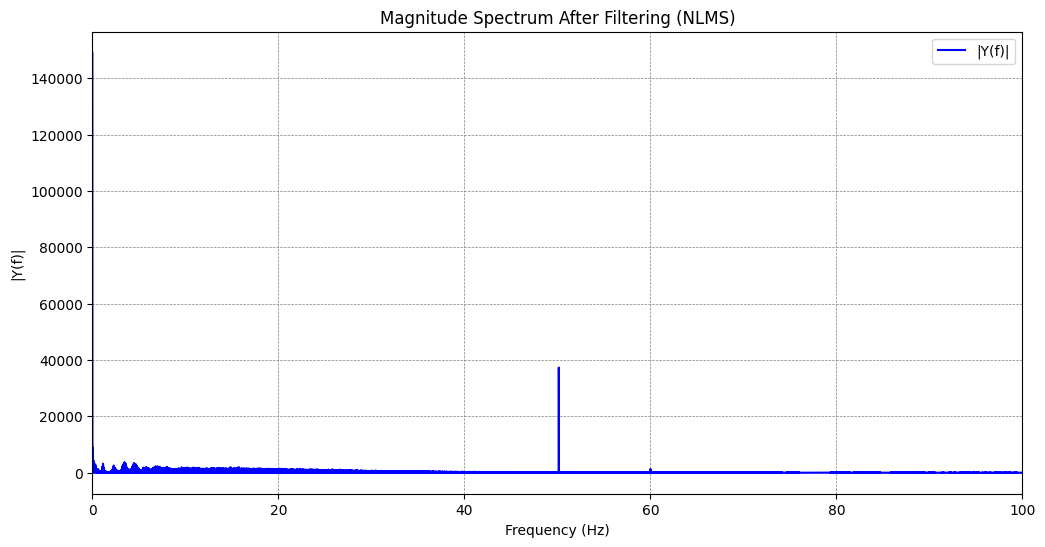

In [ ]:
# Function to plot magnitude spectrum |Y(f)| of the filtered signal
def plot_magnitude_spectrum_filtered(signal, fs, title="Magnitude Spectrum After Filtering", color="blue"):
    """
    Plots the magnitude spectrum of the signal.

    Args:
    - signal: Input signal (e.g., filtered signal).
    - fs: Sampling frequency.
    - title: Title for the plot.
    - color: Line color for the plot.
    """
    n = len(signal)  # Number of samples
    freq = np.fft.rfftfreq(n, d=1/fs)  # Frequency axis
    magnitude = np.abs(np.fft.rfft(signal))  # Magnitude spectrum

    plt.figure(figsize=(12, 6))
    plt.plot(freq, magnitude, label="|Y(f)|", color=color)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|Y(f)|")
    plt.xlim(0, 100)  # Focus on 0-100 Hz range
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

# Plot the magnitude spectrum of the NLMS filtered signal
plot_magnitude_spectrum_filtered(filtered_ecg_signal_nlms, sampling_freq, title="Magnitude Spectrum After Filtering (NLMS)", color="blue")

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate SNR
def calculate_snr(original_signal, processed_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in dB.
    """
    signal_power = np.mean(original_signal ** 2)
    noise_power = np.mean((processed_signal - original_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate %PRD
def calculate_prd(original_signal, processed_signal):
    """
    Calculate the Percentage Root Difference (%PRD).
    """
    error_signal = original_signal - processed_signal
    prd = (np.linalg.norm(error_signal) / np.linalg.norm(original_signal)) * 100
    return prd

# Function to calculate MSE
def calculate_mse(original_signal, processed_signal):
    """
    Calculate the Mean Squared Error (MSE).
    """
    mse = mean_squared_error(original_signal, processed_signal)
    return mse

# Calculate metrics for the dirty signal
snr_dirty = calculate_snr(ecg_signal, dirty_ecg_signal)
prd_dirty = calculate_prd(ecg_signal, dirty_ecg_signal)
mse_dirty = calculate_mse(ecg_signal, dirty_ecg_signal)

# Calculate metrics for the NLMS filtered signal
snr_filtered_nlms = calculate_snr(ecg_signal, filtered_ecg_signal_nlms)
prd_filtered_nlms = calculate_prd(ecg_signal, filtered_ecg_signal_nlms)
mse_filtered_nlms = calculate_mse(ecg_signal, filtered_ecg_signal_nlms)

# Print results
print("Dirty Signal Metrics:")
print(f"SNR: {snr_dirty:.2f} dB")
print(f"%PRD: {prd_dirty:.2f}%")
print(f"MSE: {mse_dirty:.6f}")

print("\nNLMS Filtered Signal Metrics:")
print(f"SNR: {snr_filtered_nlms:.2f} dB")
print(f"%PRD: {prd_filtered_nlms:.2f}%")
print(f"MSE: {mse_filtered_nlms:.6f}")

Dirty Signal Metrics:
SNR: -5.03 dB
%PRD: 178.38%
MSE: 0.499999

NLMS Filtered Signal Metrics:
SNR: 11.99 dB
%PRD: 25.14%
MSE: 0.009935


## RLS Filter

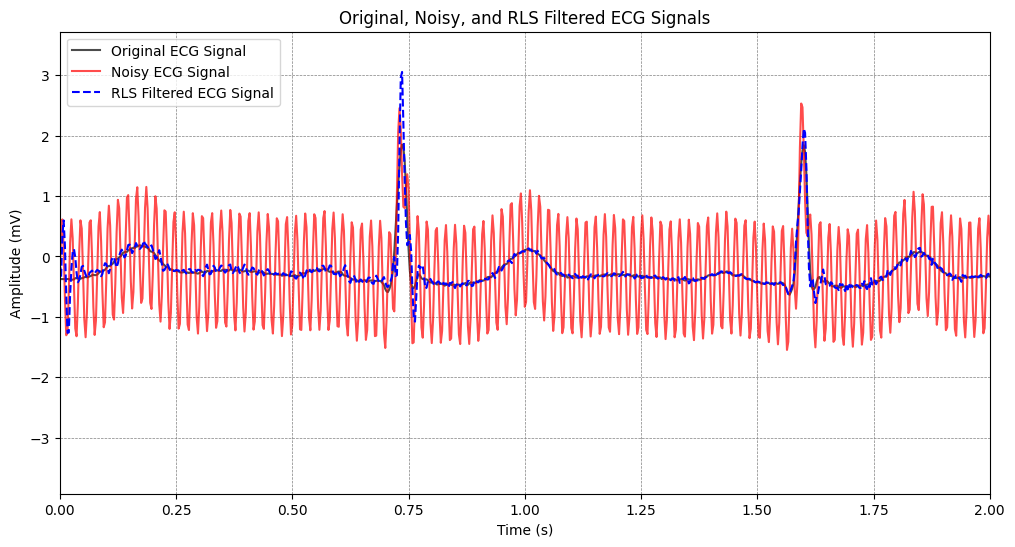

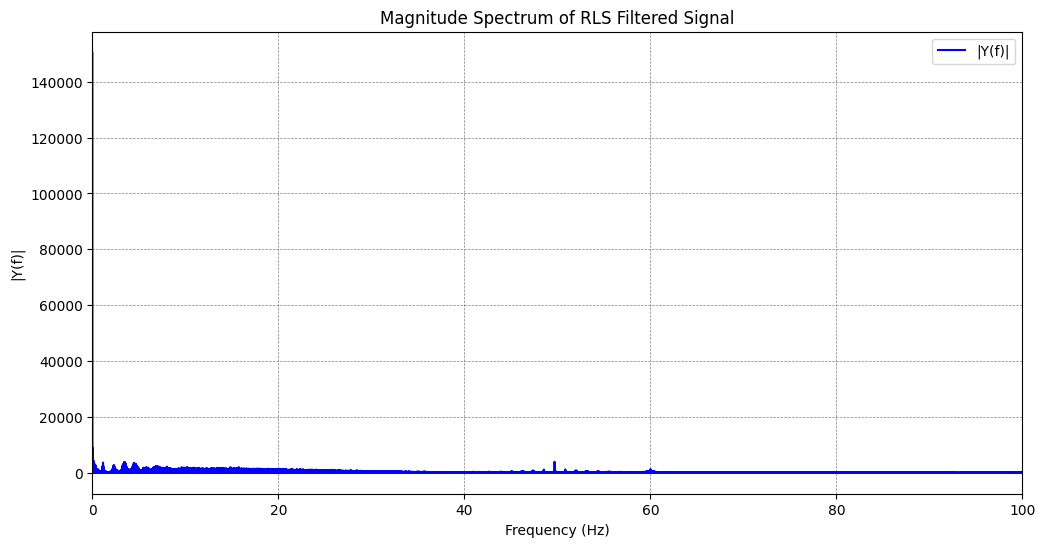

In [ ]:
# Updated RLS Filter Function
def rls_filter(dirty_signal, reference_signal, window_size=50, lam=0.995, delta=0.01):
    """
    Apply an RLS filter to the noisy signal with updated parameters.
    """
    N = len(dirty_signal)  # Length of the signal
    w = np.zeros(window_size)  # Filter weights
    P = np.eye(window_size) / delta  # Initial inverse correlation matrix
    output_signal = np.zeros(N)  # Filtered signal
    ref_window = np.zeros(window_size)  # Initialize reference window

    for n in range(N):
        # Shift the reference window and insert the new sample
        ref_window = np.insert(ref_window[:-1], 0, reference_signal[n])

        # Compute the gain vector
        k = (P @ ref_window) / (lam + ref_window.T @ P @ ref_window)

        # Compute the prediction and error
        y = ref_window.T @ w
        error = dirty_signal[n] - y

        # Update the filter weights
        w += k * error

        # Update the inverse correlation matrix
        P = (P - np.outer(k, ref_window.T @ P)) / lam

        # Store the filtered signal
        output_signal[n] = y

    return output_signal


# Apply RLS filter
filtered_ecg_signal_rls = rls_filter(dirty_ecg_signal, ecg_signal, window_size=8)

# Plot original, noisy, and RLS filtered signals
def plot_signals_with_rls(time, original_signal, noisy_signal, filtered_signal):
    """
    Plot the original, noisy, and RLS filtered signals.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_signal, label="Original ECG Signal", color="black", alpha=0.7)
    plt.plot(time, noisy_signal, label="Noisy ECG Signal", alpha=0.7, color="red")
    plt.plot(time, filtered_signal, label="RLS Filtered ECG Signal", linestyle="--", color="blue")
    plt.title("Original, Noisy, and RLS Filtered ECG Signals")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.xlim(0, 2)  # Display only the first 2 seconds for clarity
    plt.show()


# Plot magnitude spectrum for RLS filtered signal
def plot_magnitude_spectrum_rls(signal, fs, title, color):
    """
    Plot the magnitude spectrum of the RLS filtered signal.
    """
    n = len(signal)  # Number of samples
    freq = np.fft.rfftfreq(n, d=1/fs)  # Frequency axis
    magnitude = np.abs(np.fft.rfft(signal))  # Magnitude spectrum

    plt.figure(figsize=(12, 6))
    plt.plot(freq, magnitude, label="|Y(f)|", color=color)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|Y(f)|")
    plt.xlim(0, 100)  # Focus on 0-100 Hz range
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Plot original, noisy, and RLS filtered signals
plot_signals_with_rls(time, ecg_signal, dirty_ecg_signal, filtered_ecg_signal_rls)

# Plot magnitude spectrum for RLS filtered signal
plot_magnitude_spectrum_rls(filtered_ecg_signal_rls, sampling_freq, "Magnitude Spectrum of RLS Filtered Signal", color="blue")

In [ ]:
# Calculate metrics for the dirty signal
snr_dirty = calculate_snr(ecg_signal, dirty_ecg_signal)
prd_dirty = calculate_prd(ecg_signal, dirty_ecg_signal)
mse_dirty = calculate_mse(ecg_signal, dirty_ecg_signal)

# Calculate metrics for the RLS filtered signal
snr_filtered_rls = calculate_snr(ecg_signal, filtered_ecg_signal_rls)
prd_filtered_rls = calculate_prd(ecg_signal, filtered_ecg_signal_rls)
mse_filtered_rls = calculate_mse(ecg_signal, filtered_ecg_signal_rls)

# Print results for the dirty and RLS filtered signals
print("Dirty Signal Metrics:")
print(f"SNR: {snr_dirty:.2f} dB")
print(f"%PRD: {prd_dirty:.2f}%")
print(f"MSE: {mse_dirty:.6f}")

print("\nRLS Filtered Signal Metrics:")
print(f"SNR: {snr_filtered_rls:.2f} dB")
print(f"%PRD: {prd_filtered_rls:.2f}%")
print(f"MSE: {mse_filtered_rls:.6f}")

Dirty Signal Metrics:
SNR: -5.03 dB
%PRD: 178.38%
MSE: 0.500000

RLS Filtered Signal Metrics:
SNR: 15.53 dB
%PRD: 16.73%
MSE: 0.004396


## Kalman Filter

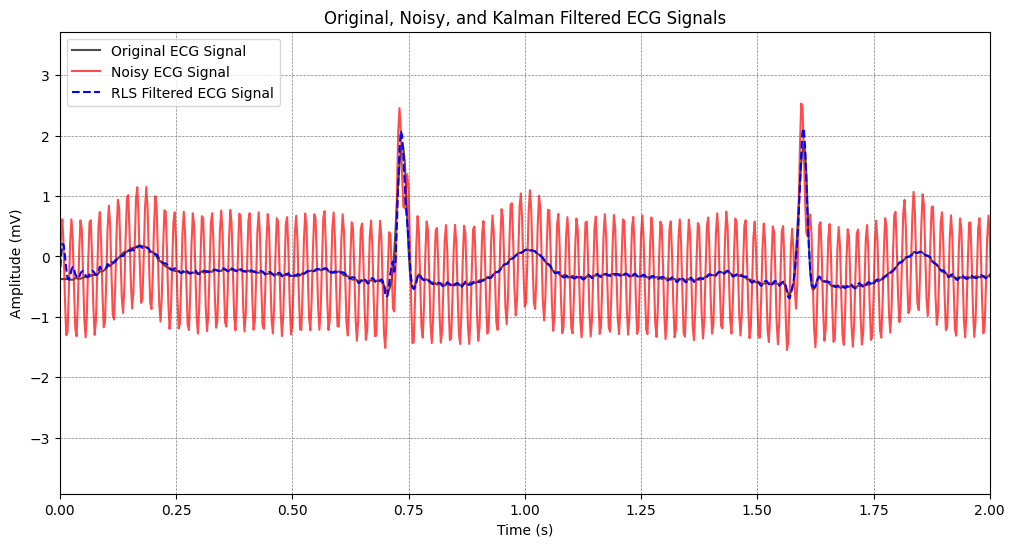

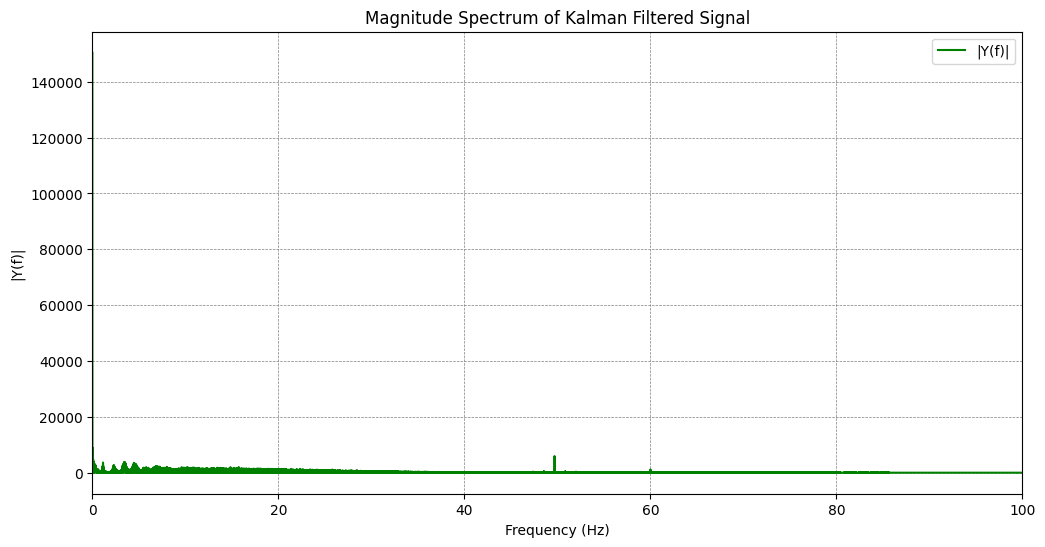

In [ ]:
import numpy as np

# Kalman Filter Function
def kalman_filter(dirty_signal, reference_signal, window_size=50, Q=1e-4, R=1e-2, delta=1.0):
    """
    Apply a Kalman filter to the noisy signal.

    Parameters:
    dirty_signal (numpy.ndarray): The noisy signal (desired output).
    reference_signal (numpy.ndarray): The reference signal (input).
    window_size (int): The number of past samples to use (window size).
    Q (float): Process noise covariance (controls the uncertainty in the model).
    R (float): Measurement noise covariance (controls the uncertainty in the measurements).
    delta (float): Initial state covariance (the uncertainty of the initial estimate).

    Returns:
    numpy.ndarray: The filtered signal.
    """
    N = len(dirty_signal)  # Length of the signal
    w = np.zeros(window_size)  # Initial filter weights (state estimate)
    P = np.eye(window_size) * delta  # Initial error covariance matrix
    output_signal = np.zeros(N)  # Filtered signal

    for n in range(N):
        # Shift the reference window and insert the new sample
        ref_window = np.insert(ref_window[:-1], 0, reference_signal[n]) if n > 0 else reference_signal[:window_size]

        # Prediction step (Kalman filter)
        y_pred = np.dot(ref_window, w)  # Predicted signal (measurement prediction)

        # Measurement residual (innovation)
        error = dirty_signal[n] - y_pred

        # Update step (Kalman gain)
        S = np.dot(np.dot(ref_window.T, P), ref_window) + R  # Innovation covariance
        K = np.dot(np.dot(P, ref_window), 1.0 / S)  # Kalman gain

        # Update the filter weights (state estimate)
        w = w + K * error

        # Update the error covariance matrix
        P = np.dot(np.eye(window_size) - np.outer(K, ref_window.T), P) + Q

        # Store the filtered signal
        output_signal[n] = np.dot(ref_window, w)

    return output_signal


# Apply Kalman filter
filtered_ecg_signal_kf = kalman_filter(dirty_ecg_signal, ecg_signal, window_size=2, Q=1e-5, R=1e-2)

# Plot original, noisy, and RLS filtered signals
def plot_signals_with_rls(time, original_signal, noisy_signal, filtered_signal):
    """
    Plot the original, noisy, and RLS filtered signals.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_signal, label="Original ECG Signal", color="black", alpha=0.7)
    plt.plot(time, noisy_signal, label="Noisy ECG Signal", alpha=0.7, color="red")
    plt.plot(time, filtered_signal, label="RLS Filtered ECG Signal", linestyle="--", color="blue")
    plt.title("Original, Noisy, and Kalman Filtered ECG Signals")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.xlim(0, 2)  # Display only the first 2 seconds for clarity
    plt.show()


# Plot magnitude spectrum for RLS filtered signal
def plot_magnitude_spectrum_rls(signal, fs, title, color):
    """
    Plot the magnitude spectrum of the RLS filtered signal.
    """
    n = len(signal)  # Number of samples
    freq = np.fft.rfftfreq(n, d=1/fs)  # Frequency axis
    magnitude = np.abs(np.fft.rfft(signal))  # Magnitude spectrum

    plt.figure(figsize=(12, 6))
    plt.plot(freq, magnitude, label="|Y(f)|", color=color)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|Y(f)|")
    plt.xlim(0, 100)  # Focus on 0-100 Hz range
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()


# Plot original, noisy, and Kalman filtered signals
plot_signals_with_rls(time, ecg_signal, dirty_ecg_signal, filtered_ecg_signal_kf)

# Plot magnitude spectrum for Kalman filtered signal
plot_magnitude_spectrum_rls(filtered_ecg_signal_kf, sampling_freq, "Magnitude Spectrum of Kalman Filtered Signal", color="green")

In [ ]:
# Calculate metrics for the dirty signal
snr_dirty = calculate_snr(ecg_signal, dirty_ecg_signal)
prd_dirty = calculate_prd(ecg_signal, dirty_ecg_signal)
mse_dirty = calculate_mse(ecg_signal, dirty_ecg_signal)

# Calculate metrics for the Kalman filtered signal
snr_filtered_kalman = calculate_snr(ecg_signal, filtered_ecg_signal_kf)
prd_filtered_kalman = calculate_prd(ecg_signal, filtered_ecg_signal_kf)
mse_filtered_kalman = calculate_mse(ecg_signal, filtered_ecg_signal_kf)

# Print results for the dirty and Kalman filtered signals
print("Dirty Signal Metrics:")
print(f"SNR: {snr_dirty:.2f} dB")
print(f"%PRD: {prd_dirty:.2f}%")
print(f"MSE: {mse_dirty:.6f}")

print("\nKalman Filtered Signal Metrics:")
print(f"SNR: {snr_filtered_kalman:.2f} dB")
print(f"%PRD: {prd_filtered_kalman:.2f}%")
print(f"MSE: {mse_filtered_kalman:.6f}")

Dirty Signal Metrics:
SNR: -5.03 dB
%PRD: 178.38%
MSE: 0.500000

Kalman Filtered Signal Metrics:
SNR: 21.48 dB
%PRD: 8.43%
MSE: 0.001117
